In [59]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [60]:
with open('ei_intermediate_file_paths.json') as file_path_file:
    file_paths = json.load(file_path_file)


SI_PREDS_INPUT_PATH = file_paths.get("smoke_impact_model_predictions.csv")
NOAA_BLS_MERGED_INPUT_PATH = file_paths.get("stage2_fs_merged_output.csv")
EI_MODEL_INPUT_PATH = file_paths.get("ei_model_output")

EI_PREDS_OUTPUT_PATH = file_paths.get("economic_impact_model_predictions.csv")

In [61]:
# Load dataset
si_preds_df = pd.read_csv(SI_PREDS_INPUT_PATH)

noaa_bls_historical_df = pd.read_csv(NOAA_BLS_MERGED_INPUT_PATH)

In [62]:
print(si_preds_df.head(5))

print(si_preds_df.columns)

   year  predicted_total_acres_burned  predicted_avg_distance  \
0  2021                  2.351687e+06              359.010931   
1  2022                  2.351687e+06              359.010931   
2  2023                  2.351687e+06              359.010931   
3  2024                  2.351687e+06              359.010931   
4  2025                  2.351687e+06              359.010931   

   total_acres_burned_normalized  distance_normalized  \
0                       0.483929             0.552325   
1                       0.483929             0.552325   
2                       0.483929             0.552325   
3                       0.483929             0.552325   
4                       0.483929             0.552325   

   total_acres_burned_weighted  distance_weighted  predicted_smoke_impact  
0                     0.483929           0.552325               34.902199  
1                     0.483929           0.552325               34.902199  
2                     0.483929        

In [63]:
print(noaa_bls_historical_df.head(5))

print(noaa_bls_historical_df.columns)

         date    bls_date  bls_curr_sae_hrs  bls_curr_laus_labor_force  \
0  2009-09-01  2009-09-01              36.8                   421301.0   
1  2009-10-01  2009-10-01              36.7                   422913.0   
2  2010-05-01  2010-05-01              38.0                   415895.0   
3  2010-06-01  2010-06-01              37.9                   421034.0   
4  2010-07-01  2010-07-01              37.4                   423239.0   

   bls_curr_laus_unemployment_rate  bls_prev_yr_sae_hrs  \
0                              9.1                 37.4   
1                              8.8                 37.0   
2                              8.2                 37.4   
3                              8.7                 37.9   
4                              8.4                 37.1   

   bls_prev_yr_laus_labor_force  bls_prev_yr_laus_unemployment_rate  \
0                      427171.0                                 5.8   
1                      431740.0                           

## MIGHT NEED TO CHANGE IT TO THIS

In [64]:
noaa_bls_historical_df['date'] = pd.to_datetime(noaa_bls_historical_df['date'])

In [65]:
noaa_bls_historical_df['month'] = noaa_bls_historical_df['date'].dt.month
noaa_bls_historical_df['year'] = noaa_bls_historical_df['date'].dt.year
fire_season_data = noaa_bls_historical_df[noaa_bls_historical_df['month'].isin([5, 6, 7, 8, 9, 10])]

In [66]:
# Ensure only May–October data is included

group_columns = ['year','noaa_tavg', 'noaa_prcp', 'bls_pct_diff_sae_hrs', 'bls_pct_diff_laus_labor_force']
fire_season_data = fire_season_data[group_columns]

# %% [Group by Year and Calculate Annual Averages for May–October]
annual_avg = fire_season_data.groupby('year').mean().reset_index()

In [67]:
print(annual_avg)

    year  noaa_tavg  noaa_prcp  bls_pct_diff_sae_hrs  \
0   2009  68.200000   9.575000             -1.207544   
1   2010  79.266667   3.396667              0.403851   
2   2011  76.633333   3.425000             -0.613112   
3   2012  76.883333   3.355000             -1.702911   
4   2013  75.633333   4.688333             -0.865232   
5   2014  75.516667   5.141667             -0.039008   
6   2015  77.116667   3.920000              1.108074   
7   2016  79.066667   3.613333              1.152528   
8   2017  75.350000   4.615000              1.855834   
9   2018  77.783333   3.551667             -3.226398   
10  2019  77.083333   6.630000             -0.269698   
11  2020  75.050000   3.300000              0.696589   
12  2021  76.133333   3.950000              1.248449   
13  2022  78.083333   3.696667              0.014441   
14  2023  76.933333   3.683333             -2.021710   
15  2024  78.960000   5.326000             -0.820411   

    bls_pct_diff_laus_labor_force  
0          

In [68]:
# %% [Prepare Future Predictions]
# Generate rows for future years
future_years = range(2025, 2051)
future_predictions = pd.DataFrame({
    'year': future_years,
    'predicted_tavg': np.nan,
    'predicted_prcp': np.nan,
    'predicted_pct_diff_sae_hrs': np.nan,
    'predicted_pct_diff_labor_force': np.nan
})

# Create a copy of the annual averages to dynamically update rolling averages
dynamic_annual_avg = annual_avg.copy()

# Use dynamic rolling averages to predict future values
for i, row in future_predictions.iterrows():
    # Calculate rolling averages from the most recent 3 years
    rolling_tavg = dynamic_annual_avg['noaa_tavg'].rolling(window=5, min_periods=1).mean().iloc[-1]
    rolling_prcp = dynamic_annual_avg['noaa_prcp'].rolling(window=5, min_periods=1).mean().iloc[-1]
    rolling_sae_hrs = dynamic_annual_avg['bls_pct_diff_sae_hrs'].rolling(window=5, min_periods=1).mean().iloc[-1]
    rolling_labor_force = dynamic_annual_avg['bls_pct_diff_laus_labor_force'].rolling(window=5, min_periods=1).mean().iloc[-1]

    # Assign the calculated rolling averages as predictions for the future year
    future_predictions.loc[i, 'predicted_tavg'] = rolling_tavg
    future_predictions.loc[i, 'predicted_prcp'] = rolling_prcp
    future_predictions.loc[i, 'predicted_pct_diff_sae_hrs'] = rolling_sae_hrs
    future_predictions.loc[i, 'predicted_pct_diff_labor_force'] = rolling_labor_force

    # Append the predicted values to the dynamic dataset
    new_row = {
        'year': row['year'],
        'noaa_tavg': rolling_tavg,
        'noaa_prcp': rolling_prcp,
        'bls_pct_diff_sae_hrs': rolling_sae_hrs,
        'bls_pct_diff_laus_labor_force': rolling_labor_force
    }
    dynamic_annual_avg = pd.concat([dynamic_annual_avg, pd.DataFrame([new_row])], ignore_index=True)

# %% [Merge with Smoke Impact Predictions]
# Merge with smoke impact predictions on the year
future_predictions = future_predictions.merge(si_preds_df[['year', 'predicted_smoke_impact']], on='year', how='left')

# Rename columns to align with the economic impact model expectations
future_predictions.rename(columns={
    'predicted_smoke_impact': 'scaled_avg_daily_smoke_impact',
    'predicted_tavg': 'noaa_tavg',
    'predicted_prcp': 'noaa_prcp',
    'predicted_pct_diff_sae_hrs': 'bls_pct_diff_sae_hrs',
    'predicted_pct_diff_labor_force': 'bls_pct_diff_laus_labor_force'
}, inplace=True)

# %% [Save Predictions for Review]
future_predictions.to_csv("future_predictions_updated.csv", index=False)
print("Updated future predictions saved to 'future_predictions_updated.csv'.")


Updated future predictions saved to 'future_predictions_updated.csv'.


In [69]:


# # %% [3-Year Moving Average]
# # Calculate 3-year moving averages for relevant columns
# annual_avg['3yr_avg_tavg'] = annual_avg['noaa_tavg'].rolling(window=3, min_periods=1).mean()
# annual_avg['3yr_avg_prcp'] = annual_avg['noaa_prcp'].rolling(window=3, min_periods=1).mean()
# annual_avg['3yr_avg_pct_diff_sae_hrs'] = annual_avg['bls_pct_diff_sae_hrs'].rolling(window=3, min_periods=1).mean()
# annual_avg['3yr_avg_pct_diff_labor_force'] = annual_avg['bls_pct_diff_laus_labor_force'].rolling(window=3, min_periods=1).mean()

# # %% [Prepare Future Predictions]
# # Generate rows for future years
# future_years = range(2025, 2051)
# future_predictions = pd.DataFrame({
#     'year': future_years,
#     'predicted_tavg': np.nan,
#     'predicted_prcp': np.nan,
#     'predicted_pct_diff_sae_hrs': np.nan,
#     'predicted_pct_diff_labor_force': np.nan
# })

# # Use the last available 3-year moving average values to predict future data
# for i, row in future_predictions.iterrows():
#     future_predictions.loc[i, 'predicted_tavg'] = annual_avg['3yr_avg_tavg'].iloc[-1]
#     future_predictions.loc[i, 'predicted_prcp'] = annual_avg['3yr_avg_prcp'].iloc[-1]
#     future_predictions.loc[i, 'predicted_pct_diff_sae_hrs'] = annual_avg['3yr_avg_pct_diff_sae_hrs'].iloc[-1]
#     future_predictions.loc[i, 'predicted_pct_diff_labor_force'] = annual_avg['3yr_avg_pct_diff_labor_force'].iloc[-1]

# # %% [Merge with Smoke Impact Predictions]
# # Merge with smoke impact predictions on the year
# future_predictions = future_predictions.merge(si_preds_df[['year', 'predicted_smoke_impact']], on='year', how='left')

# # Rename columns to align with the economic impact model expectations
# future_predictions.rename(columns={
#     'predicted_smoke_impact': 'scaled_avg_daily_smoke_impact',
#     'predicted_tavg': 'noaa_tavg',
#     'predicted_prcp': 'noaa_prcp',
#     'predicted_pct_diff_sae_hrs': 'bls_pct_diff_sae_hrs',
#     'predicted_pct_diff_labor_force': 'bls_pct_diff_laus_labor_force'
# }, inplace=True)

# # %% [Prepare Data for Prediction]
# # Select features required for the model



In [70]:
# print(future_predictions)

# future_predictions.to_csv("future_predictions.csv")

In [71]:
# Load the trained Gradient Boosting model
with open(EI_MODEL_INPUT_PATH , 'rb') as model_file:
    economic_impact_model = pickle.load(model_file)

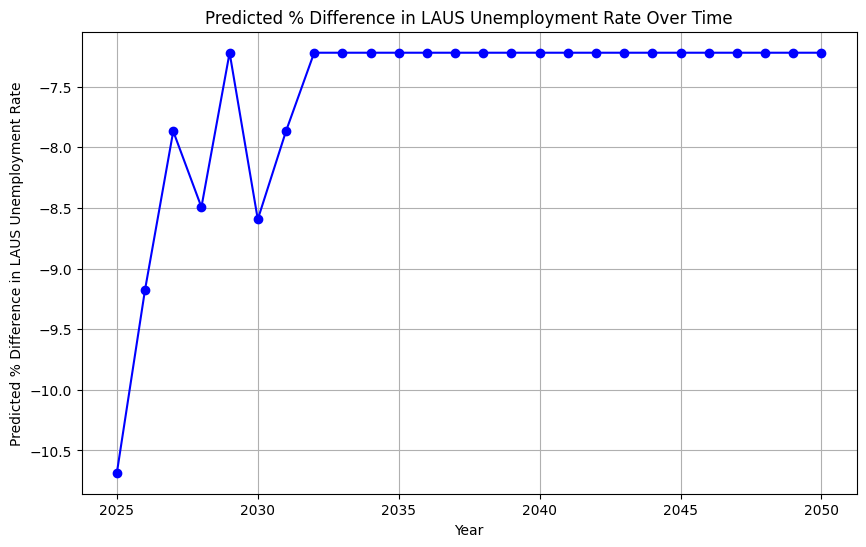

Predictions saved to final-output/economic_impact_estimate_mdl_future_prediction.csv


In [72]:
prediction_features = ['noaa_tavg', 'noaa_prcp', 'scaled_avg_daily_smoke_impact', 'bls_pct_diff_sae_hrs', 'bls_pct_diff_laus_labor_force']

# Extract features for prediction
X_future = future_predictions[prediction_features]

# %% [Make Predictions]
future_predictions['pct_diff_laus_unemployment_rate'] = economic_impact_model.predict(X_future)

# %% [Plot Predictions]
plt.figure(figsize=(10, 6))
plt.plot(future_predictions['year'], future_predictions['pct_diff_laus_unemployment_rate'], marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Predicted % Difference in LAUS Unemployment Rate')
plt.title('Predicted % Difference in LAUS Unemployment Rate Over Time')
plt.grid(True)
plt.show()

# %% [Save Predictions]
future_predictions.to_csv(EI_PREDS_OUTPUT_PATH, index=False)
print(f"Predictions saved to {EI_PREDS_OUTPUT_PATH}")